In [ ]:
!pip -q install timm==1.0.9
import os
import glob
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import timm

from google.colab import drive
drive.mount('/content/drive')

DRIVE_ZIP_PATH = "/content/drive/MyDrive/CircuitGuard_Project/defect_crops_final.zip"
MODEL_DIR = "/content/drive/MyDrive/CircuitGuard_Project/models"
os.makedirs(MODEL_DIR, exist_ok=True)
BEST_CHECKPOINT = os.path.join(MODEL_DIR, "circuitguard_efficientnet_b4_v2.pth")

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-4
NUM_WORKERS = 2
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using Device: {DEVICE}")

if not os.path.exists("/content/defect_crops_fixed") and not os.path.exists("/content/Short"):
    print(f"📂 Unzipping dataset...")
    if not os.path.exists(DRIVE_ZIP_PATH):
         if os.path.exists("/content/defect_crops_fixed.zip"):
             DRIVE_ZIP_PATH = "/content/defect_crops_fixed.zip"
         else:
             raise FileNotFoundError(f"❌ Error: Could not find {DRIVE_ZIP_PATH}. Please upload zip to Drive or Colab.")

    !unzip -q "{DRIVE_ZIP_PATH}" -d /content/
    print("✅ Unzip Complete.")

possible_roots = [
    "/content/defect_crops_fixed",
    "/content/content/defect_crops_fixed",
    "/content"
]

LOCAL_DATA_DIR = None
for root in possible_roots:
    if os.path.exists(os.path.join(root, "Short")):
        LOCAL_DATA_DIR = root
        break

if LOCAL_DATA_DIR is None:
    print("🔍 Searching for dataset location...")
    for root, dirs, files in os.walk("/content"):
        if "Short" in dirs:
            LOCAL_DATA_DIR = root
            break

if LOCAL_DATA_DIR:
    print(f"✅ Dataset found at: {LOCAL_DATA_DIR}")
else:
    print("❌ ERROR: Could not find dataset folders (Short, Open_circuit, etc.)")
    print("Contents of /content/:", os.listdir("/content"))
    raise FileNotFoundError("Dataset extraction failed. Check the logs above.")

classes = sorted([d for d in os.listdir(LOCAL_DATA_DIR) if os.path.isdir(os.path.join(LOCAL_DATA_DIR, d)) and d in ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']])
print(f"📋 Classes: {classes}")

all_files = []
all_labels = []
for cls in classes:
    files = glob.glob(os.path.join(LOCAL_DATA_DIR, cls, "*.png"))
    all_files.extend(files)
    all_labels.extend([cls] * len(files))

print(f"📊 Total Dataset Size: {len(all_files)} images")

train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=SEED
)
class_to_idx = {c: i for i, c in enumerate(classes)}

In [ ]:
class PCBDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert('RGB')
        label = class_to_idx[self.labels[idx]]

        if self.transform:
            img = self.transform(img)
        return img, label

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = PCBDataset(train_files, train_labels, transform=train_tf)
val_ds = PCBDataset(val_files, val_labels, transform=val_tf)

print("⚖️ Calculating Sampler Weights...")
train_indices = [class_to_idx[label] for label in train_labels]
class_counts = Counter(train_indices)

weights = []
for i in range(len(classes)):
    c = class_counts[i]
    weight = 1.0 / np.sqrt(c) if c > 0 else 0
    weights.append(weight)

sample_weights = [weights[i] for i in train_indices]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using Device: cuda
📂 Unzipping dataset...
✅ Unzip Complete.
🔍 Searching for dataset location...
✅ Dataset found at: /content/content/defect_crops_final
📋 Classes: ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']
📊 Total Dataset Size: 2936 images
⚖️ Calculating Sampler Weights...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]


🚀 STARTING TRAINING (EfficientNet-B4)...


Epoch 1/25 | Train Loss: 2.1921 Acc: 0.2926 | Val Loss: 1.6884 Acc: 0.4065 F1: 0.3992
⭐ Model Saved! (Best F1: 0.3992)


Epoch 2/25 | Train Loss: 1.5528 Acc: 0.4476 | Val Loss: 1.3305 Acc: 0.5068 F1: 0.5036
⭐ Model Saved! (Best F1: 0.5036)


Epoch 3/25 | Train Loss: 1.2217 Acc: 0.5456 | Val Loss: 1.0725 Acc: 0.6156 F1: 0.6120
⭐ Model Saved! (Best F1: 0.6120)


Epoch 4/25 | Train Loss: 1.0033 Acc: 0.6197 | Val Loss: 0.9354 Acc: 0.6548 F1: 0.6527
⭐ Model Saved! (Best F1: 0.6527)


Epoch 5/25 | Train Loss: 0.8409 Acc: 0.6767 | Val Loss: 0.8010 Acc: 0.7024 F1: 0.6968
⭐ Model Saved! (Best F1: 0.6968)


Epoch 6/25 | Train Loss: 0.7540 Acc: 0.7236 | Val Loss: 0.6745 Acc: 0.7602 F1: 0.7559
⭐ Model Saved! (Best F1: 0.7559)


Epoch 7/25 | Train Loss: 0.6315 Acc: 0.7636 | Val Loss: 0.5961 Acc: 0.7704 F1: 0.7652
⭐ Model Saved! (Best F1: 0.7652)


Epoch 8/25 | Train Loss: 0.5567 Acc: 0.7922 | Val Loss: 0.5189 Acc: 0.8044 F1: 0.8009
⭐ Model Saved! (Best F1: 0.8009)


Epoch 9/25 | Train Loss: 0.4738 Acc: 0.8237 | Val Loss: 0.4579 Acc: 0.8316 F1: 0.8263
⭐ Model Saved! (Best F1: 0.8263)


Epoch 10/25 | Train Loss: 0.4184 Acc: 0.8365 | Val Loss: 0.4204 Acc: 0.8435 F1: 0.8395
⭐ Model Saved! (Best F1: 0.8395)


Epoch 11/25 | Train Loss: 0.3370 Acc: 0.8727 | Val Loss: 0.3442 Acc: 0.8759 F1: 0.8749
⭐ Model Saved! (Best F1: 0.8749)


Epoch 12/25 | Train Loss: 0.3226 Acc: 0.8816 | Val Loss: 0.3533 Acc: 0.8776 F1: 0.8762
⭐ Model Saved! (Best F1: 0.8762)


Epoch 13/25 | Train Loss: 0.2887 Acc: 0.8918 | Val Loss: 0.3213 Acc: 0.8810 F1: 0.8797
⭐ Model Saved! (Best F1: 0.8797)


Epoch 14/25 | Train Loss: 0.2514 Acc: 0.9029 | Val Loss: 0.2813 Acc: 0.8997 F1: 0.8984
⭐ Model Saved! (Best F1: 0.8984)


Epoch 15/25 | Train Loss: 0.2173 Acc: 0.9165 | Val Loss: 0.2748 Acc: 0.9031 F1: 0.9014
⭐ Model Saved! (Best F1: 0.9014)


Epoch 16/25 | Train Loss: 0.2150 Acc: 0.9148 | Val Loss: 0.2686 Acc: 0.8946 F1: 0.8928


Epoch 17/25 | Train Loss: 0.1841 Acc: 0.9272 | Val Loss: 0.2215 Acc: 0.9167 F1: 0.9161
⭐ Model Saved! (Best F1: 0.9161)


Epoch 18/25 | Train Loss: 0.1878 Acc: 0.9319 | Val Loss: 0.1999 Acc: 0.9269 F1: 0.9265
⭐ Model Saved! (Best F1: 0.9265)


Epoch 19/25 | Train Loss: 0.1650 Acc: 0.9365 | Val Loss: 0.1890 Acc: 0.9337 F1: 0.9335
⭐ Model Saved! (Best F1: 0.9335)


Epoch 20/25 | Train Loss: 0.1465 Acc: 0.9451 | Val Loss: 0.1764 Acc: 0.9388 F1: 0.9392
⭐ Model Saved! (Best F1: 0.9392)


Epoch 21/25 | Train Loss: 0.1507 Acc: 0.9408 | Val Loss: 0.1766 Acc: 0.9371 F1: 0.9366


Epoch 22/25 | Train Loss: 0.1365 Acc: 0.9489 | Val Loss: 0.1713 Acc: 0.9337 F1: 0.9334


Epoch 23/25 | Train Loss: 0.1028 Acc: 0.9612 | Val Loss: 0.1613 Acc: 0.9337 F1: 0.9332


Epoch 24/25 | Train Loss: 0.1250 Acc: 0.9514 | Val Loss: 0.1652 Acc: 0.9269 F1: 0.9262


Epoch 25/25 | Train Loss: 0.1199 Acc: 0.9549 | Val Loss: 0.1572 Acc: 0.9371 F1: 0.9367

✅ Training Complete. Best F1: 0.9392



FINAL CLASSIFICATION REPORT
                 precision    recall  f1-score   support

   Missing_hole     1.0000    1.0000    1.0000        99
     Mouse_bite     0.8496    0.9505    0.8972       101
   Open_circuit     0.9184    0.8911    0.9045       101
          Short     0.9510    0.9510    0.9510       102
           Spur     0.9759    0.8804    0.9257        92
Spurious_copper     0.9570    0.9570    0.9570        93

       accuracy                         0.9388       588
      macro avg     0.9420    0.9383    0.9392       588
   weighted avg     0.9411    0.9388    0.9390       588



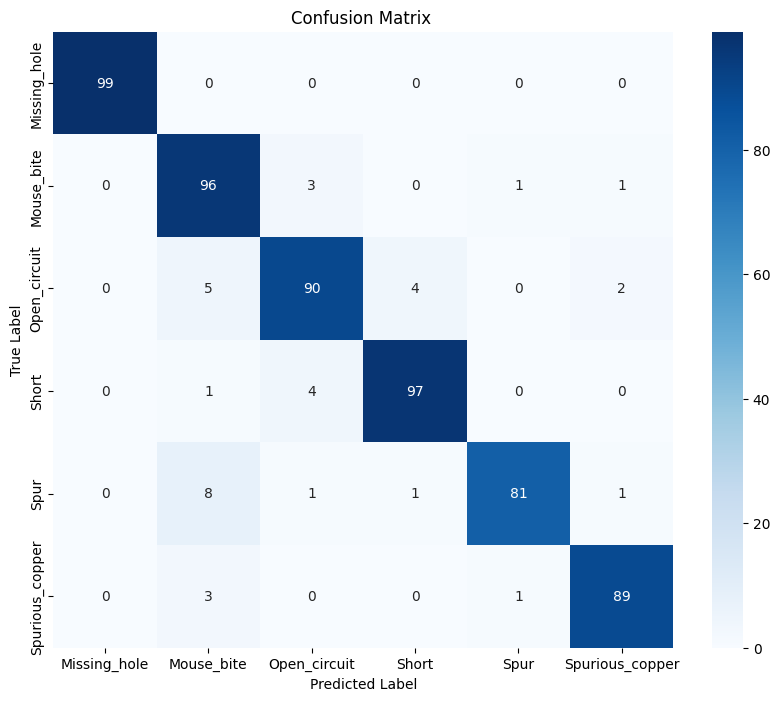

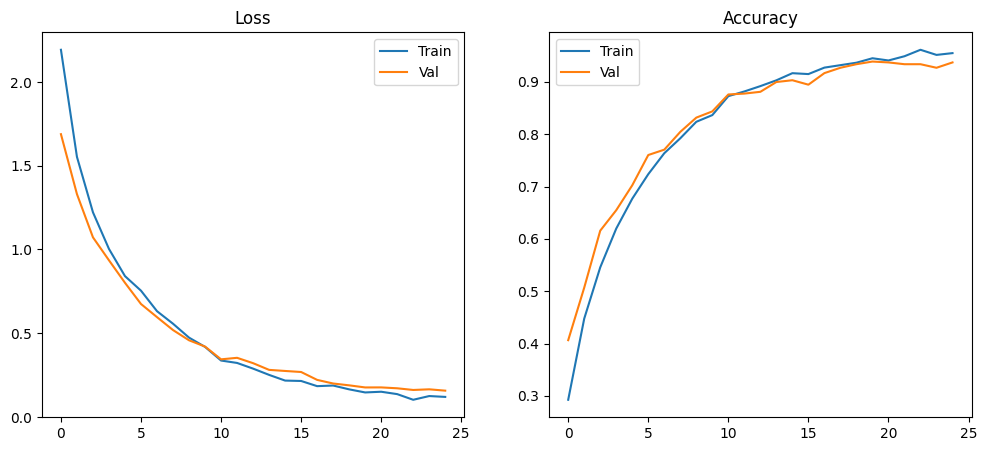

📄 Inference Helper saved to: /content/drive/MyDrive/CircuitGuard_Project/models/inference_helper.py


In [ ]:
model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=len(classes))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3)
scaler = torch.amp.GradScaler('cuda')

def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, lbls in tqdm(loader, desc="Training", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, lbls)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(lbls).sum().item()
        total += imgs.size(0)
    return total_loss / total, correct / total

def validate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_lbls = [], []

    with torch.no_grad():
        for imgs, lbls in tqdm(loader, desc="Validating", leave=False):
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)

            with torch.amp.autocast('cuda'):
                outputs = model(imgs)
                loss = criterion(outputs, lbls)

            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(lbls).sum().item()
            total += imgs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_lbls.extend(lbls.cpu().numpy())

    f1 = f1_score(all_lbls, all_preds, average='macro')
    return total_loss / total, correct / total, f1, all_lbls, all_preds

best_f1 = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("\n🚀 STARTING TRAINING (EfficientNet-B4)...")
for epoch in range(EPOCHS):
    t_loss, t_acc = train_one_epoch(model, train_loader)
    v_loss, v_acc, v_f1, _, _ = validate(model, val_loader)

    scheduler.step(v_f1)

    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_acc'].append(t_acc)
    history['val_acc'].append(v_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {t_loss:.4f} Acc: {t_acc:.4f} | Val Loss: {v_loss:.4f} Acc: {v_acc:.4f} F1: {v_f1:.4f}")

    if v_f1 > best_f1:
        best_f1 = v_f1
        torch.save({'model': model.state_dict(), 'classes': classes}, BEST_CHECKPOINT)
        print(f"⭐ Model Saved! (Best F1: {best_f1:.4f})")

print(f"\n✅ Training Complete. Best F1: {best_f1:.4f}")

ckpt = torch.load(BEST_CHECKPOINT)
model.load_state_dict(ckpt['model'])
_, _, _, y_true, y_pred = validate(model, val_loader)

print("\n" + "="*50)
print("FINAL CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.title("Confusion Matrix ")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()


helper_path = os.path.join(MODEL_DIR, "inference_helper.py")
with open(helper_path, "w") as f:
    f.write(f"""
import torch, timm
from PIL import Image
from torchvision import transforms

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = '{BEST_CHECKPOINT}'
CLASSES = {classes}

transform = transforms.Compose([
    transforms.Resize(({IMG_SIZE}, {IMG_SIZE})),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

def load_model():
    model = timm.create_model('efficientnet_b4', pretrained=False, num_classes=len(CLASSES))
    ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt['model'])
    model.to(DEVICE).eval()
    return model

def predict(model, img_path):
    img = Image.open(img_path).convert('RGB')
    t = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(t)
        idx = out.argmax(1).item()
    return CLASSES[idx]
""")
print(f"📄 Inference Helper saved to: {helper_path}")